<hr> 

## Анализ временных рядов: объем потребления и ВВП Австрии 1970-2020 гг. 

Всеволод Котенёв, Санкт-Петербургский государственный университет

### Подготовка. Мотивировка работы, импорт нужного функционала

На сегодняшний момент моделирование национального благосостояния и экономического роста не перестает быть актуальной темой исследований с применением математических методов. Приведем формулу ВВП по методу расходов - ключевого валового показателя благосостояния экономики: 

$GDP = C + I + G + NX (exp - imp)$

Чаще всего врвменная динамика ВВП и его компонент представляет собой нестационарные данные. По этой причине исследователи выделяют модели коинтеграции и коррекции ошибок для того, чтобы более детально исследовать взаимосвязи. <br><br>Для проведения работы были выгружены данные Всемирного банка по ВВП и потреблению в Австрии с 1970 по 2020 год (50 лет). 
<br><br>
#### В рамках данного проекта были выдвинуты следующие предположения:
<br> **Гипотеза 1**. Ряды ВВП и потребления - первого порядка интегрируемости, то есть разностно-стационарные (DS) 
<br><br> **Гипотеза 2**. Между рядами ВВП и потребеления возможны модели коинтеграции и коррекции ошибок как в *простой* (линейной) форме (ECM), так и *векторной* форме (VECM). Для векторной формы коинтеграции возможно как минимум одно коинтеграционное соотношение и как минимум один *статистически значимый коэффициент корректировки* (ЕС)
<br><br> **Гипотеза 3**. Как миниму для одного из рядов возможен подбор модели ARIMA (p,d,q)
<br><br> **Гипотеза 4**. Для модели, упомнятой в Гипотезе 3, возможен ARCH-эффект и моделирование GARCH

<hr>

Импорт необходимых библиотек для **структурирования, препарирования и визуализации данных**
<br>
<br> A. **NumPy** - библиотека для представления данных в многомернях массивах 
<br> B. **Pandas** - 'Panel Data' - библиотека для представления данных в таблицах и их препарирования 
<br> C. **Matplotlib & Seaborn** - библиотеки для визуализации данных в виде графиков, диаграмм и прочего. 
<br> D. **Statsmodels** - библиотека для построения регрессионных моделей, моделей на _временных рядах_, проведения статистических тестов
<br> E. **Sci-Kit Learn**  - библиотека для построения предсказательных моделей (регрессия, модели с дискретной зависимой переменной, прочее). 
<br> F. **ARCH** - библиотека для проверки ARCH-эффекта и построения GARCH-моделей 

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.tsa.api as timeseries 
# Взятие разницы = pd.DataFrame.diff() или pd.Series.diff()

#### Функционал тестов на единичные корни, а также диагностики ARCH-эффекта и построения ARCH/GARCH

In [7]:
from arch.unitroot import ADF, KPSS, DFGLS
from arch import arch_model
# sm.stats.diagnostic.het_arch
# Также могут быть полезны другие функции для проведения тестов на ЕК, но из библиотеки Statsmodels 
# timeseries.stattools.adfuller()
# timseries.stattools.kpss()

#### Функционал построения ACF, PACF,  ARIMA (p,d,q)

In [8]:
# timeseries.stattools.acf
# timeseries.stattools.pacf

# timeseries.stattols.q_stat
# sm.stats.acorr_ljungbox(return_df = True)

# timseries stattools.breakvar_heteroskedasticity_test

# timeseries.ARIMA
# timeseries.ARMA 

#### Функционал **теста на причинность по Грейнджеру**

In [9]:
# timeseries.stattools.grangercausalitytests()

#### Функционал VAR, VECM, теста Йохансена на число коинт.соотношений

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
# timeseries.VAR()
# timeseries.VECM()

<hr>

# Описание данных

In [11]:
df_cons = pd.read_csv('cons.csv')
df_gdp = pd.read_csv('gdp.csv')

In [12]:
cons_AUS = df_cons.loc[df_cons['Country Name'] == 'Austria', '1970':'2020'].transpose().reset_index()
gdp_AUS = df_gdp.loc[df_cons['Country Name'] == 'Austria', '1970':'2020'].transpose().reset_index()

In [13]:
final_AUS = cons_AUS.merge(gdp_AUS, how = 'inner', on = 'index')
final_AUS.columns = ['year', 'consumption', 'GDP'] 
final_AUS.tail()

,year,consumption,GDP
46,2016,2.844651e+11,3.955686e+11
47,2017,2.996405e+11,4.162073e+11
48,2018,3.241125e+11,4.548726e+11
49,2019,3.166583e+11,4.450754e+11
50,2020,3.074606e+11,4.309474e+11


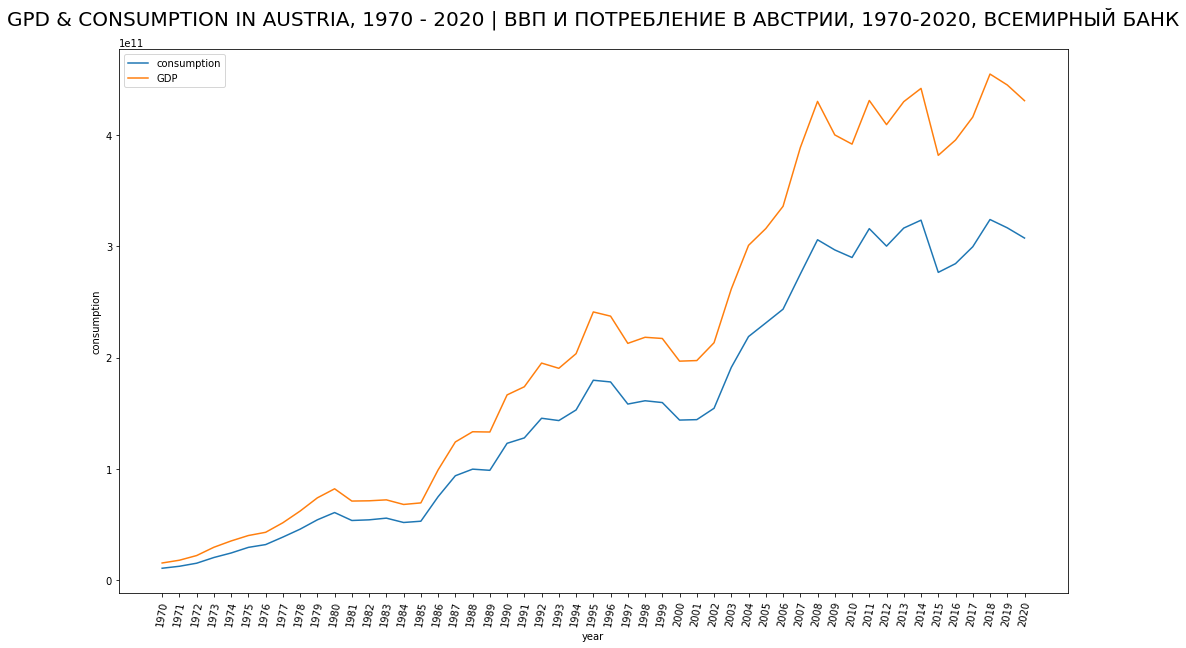

In [14]:
fig, ax = plt.subplots(figsize = (17, 10))
for col in final_AUS.columns[1:]: 
    sns.lineplot(ax = ax, 
                 x = final_AUS.year, 
                 y = final_AUS[col], 
                 label = col)
ax.legend()
ax.set_title('GPD & Consumption in Austria, 1970 - 2020 | ВВП и потребление в Австрии, 1970-2020, Всемирный банк'.upper(), size = 20, pad = 25)
plt.xticks(rotation = 80)
plt.show()

<hr>

# Задача 1. Тесты на единичные корни и проверка порядка интегрируемости рядов

###  Ряд Consumption - валовый объем потребления

In [15]:
# Расширенный тест Дики-Фуллера: без константы и тренда, с константой, с константой и трендом
test_results = []
for trend_type in ['n', 'c', 'ct']: 
    test_results.append(ADF(final_AUS.consumption, trend = trend_type))

#### ПОЯСНЕНИЕ: как функционал Python проводит ADF-тест?
В библиотеке ARCH, которая используется для проведения тестов на единичные корни, уже встроен функционал по *отбору лагов для включения в ADF-уравнение на основе критериев AIC и BIC*. Более того, функция сама корректирует модель, если находит в ее остатках автокрреляцию, поэтому результаты теста надёжны. 

<hr>

### Модификация 1: тестовое ADF-уравнение без включения константы и тренда

In [16]:
print(test_results[0].regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.075
Model:                            OLS   Adj. R-squared (uncentered):              0.056
Method:                 Least Squares   F-statistic:                              3.977
Date:                Mon, 27 Dec 2021   Prob (F-statistic):                      0.0517
Time:                        22:17:42   Log-Likelihood:                         -1243.6
No. Observations:                  50   AIC:                                      2489.
Df Residuals:                      49   BIC:                                      2491.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Сокращенный результат:

In [17]:
print(test_results[0].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  1.994
P-value                         0.990
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.61 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Вывод: р-значение принятия нулевой гипотезы 99%, принимается Н(0) о DS-характере ряда. Т.о., ряд нестационарный. 

<hr>

### Модификация 2: тестовое ADF-уравнение с включением только константы

In [18]:
print(test_results[1].regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2193
Date:                Mon, 27 Dec 2021   Prob (F-statistic):              0.642
Time:                        22:17:43   Log-Likelihood:                -1241.7
No. Observations:                  50   AIC:                             2487.
Df Residuals:                      48   BIC:                             2491.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0095      0.020     -0.468      0.6

#### Сокращенный результат:

In [19]:
print(test_results[1].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.468
P-value                         0.898
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.57 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Вывод: р-значение принятия нулевой гипотезы 89,8%, принимается Н(0) о DS-характере ряда. Т.о., ряд нестационарный. 

<hr>

### Модификация 3: тестовое ADF-уравнение с включением константы и тренда

In [20]:
print(test_results[2].regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2.750
Date:                Mon, 27 Dec 2021   Prob (F-statistic):             0.0210
Time:                        22:17:43   Log-Likelihood:                -1110.5
No. Observations:                  45   AIC:                             2237.
Df Residuals:                      37   BIC:                             2251.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.4812      0.125     -3.862      0.0

#### Сокращенный результат:

In [21]:
print(test_results[2].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.862
P-value                         0.014
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.18 (1%), -3.51 (5%), -3.19 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### ВЫВОД: р-значение принятия нулевой гипотезы 1,4%, принимается Н(1) о TS-характере ряда. Тренд во вспомогательной регрессии ADF статистически *значим*. Т.о., ряд нестационарный. 

<hr>

###  Ряд DGP - ВВП

In [22]:
test_results_1 = []
for trend_type in ['n', 'c', 'ct']: 
    test_results_1.append(ADF(final_AUS.GDP, trend = trend_type))

### Модификация 1: тестовое ADF-уравнение без включения константы и тренда

In [23]:
print(test_results_1[0].regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.076
Model:                            OLS   Adj. R-squared (uncentered):              0.058
Method:                 Least Squares   F-statistic:                              4.058
Date:                Mon, 27 Dec 2021   Prob (F-statistic):                      0.0495
Time:                        22:17:43   Log-Likelihood:                         -1260.9
No. Observations:                  50   AIC:                                      2524.
Df Residuals:                      49   BIC:                                      2526.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Сокращенный результат:

In [24]:
print(test_results_1[0].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  2.014
P-value                         0.991
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.61 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### ВЫВОД: р-значение принятия нулевой гипотезы 99,1%, принимается Н(0) о DS-характере ряда. Т.о., ряд нестационарный. 

<hr>

### Модификация 2: тестовое ADF-уравнение с включением константы

In [25]:
print(test_results_1[1].regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.1387
Date:                Mon, 27 Dec 2021   Prob (F-statistic):              0.711
Time:                        22:17:43   Log-Likelihood:                -1259.1
No. Observations:                  50   AIC:                             2522.
Df Residuals:                      48   BIC:                             2526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0078      0.021     -0.372      0.7

#### Сокращенный результат:

In [26]:
print(test_results_1[1].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.372
P-value                         0.915
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.57 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Вывод: р-значение принятия нулевой гипотезы 91,5%, принимается Н(0) о DS-характере ряда. Т.о., ряд нестационарный. 

### Модификация 3: тестовое ADF-уравнение с включением константы и линейного тренда

In [27]:
print(test_results_1[2].regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     2.580
Date:                Mon, 27 Dec 2021   Prob (F-statistic):             0.0285
Time:                        22:17:43   Log-Likelihood:                -1126.6
No. Observations:                  45   AIC:                             2269.
Df Residuals:                      37   BIC:                             2284.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.4439      0.124     -3.567      0.0

#### Сокращенный результат:

In [28]:
print(test_results_1[2].summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.567
P-value                         0.033
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.18 (1%), -3.51 (5%), -3.19 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### ВЫВОД: р-значение принятия нулевой гипотезы 3,3%, принимается Н(1) о TS-характере ряда. Тренд во вспомогательной регрессии ADF статистически *значим*. Т.о., ряд нестационарный. 

<hr>

### Дополнительная проверка ряда CONSUMPTION с помощью ADF-GLS

In [29]:
# Доп проверка ADF-GLS для consumption
df_gls_CONS = DFGLS(final_AUS.consumption, trend = 'c')

#### Сводная таблица с результатом:

In [30]:
print(df_gls_CONS.summary())

      Dickey-Fuller GLS Results      
Test Statistic                  0.374
P-value                         0.807
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -2.93 (1%), -2.30 (5%), -1.99 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Дополнительная проверка ряда GDP с помощью ADF-GLS

In [31]:
# Доп.проверка ADF-GLS для GDP
df_gls_GDP = DFGLS(final_AUS.GDP, trend = 'c')

#### Сводная таблица с результатом:

In [32]:
print(df_gls_GDP.summary())

      Dickey-Fuller GLS Results      
Test Statistic                  0.843
P-value                         0.902
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.92 (1%), -2.29 (5%), -1.98 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Вывод: результаты ADF-GLS позволяют установить, что оба ряда являются не стационарными относительно тренда, а именно процессами *случайного блуждания c ненулевым дрейфом* , которые очень часто ложно принимаются ADF-тестом за TS-ряды (Подкорытова О.А, Соколов М.В. Анализ временных рядов. М.: Юрайт, 2021. С.80)

<hr> 

### Первая разность CONSUMPTION - d_cons

In [33]:
d_cons = final_AUS.consumption.diff().dropna()

AxesSubplot(0.125,0.125;0.775x0.755)


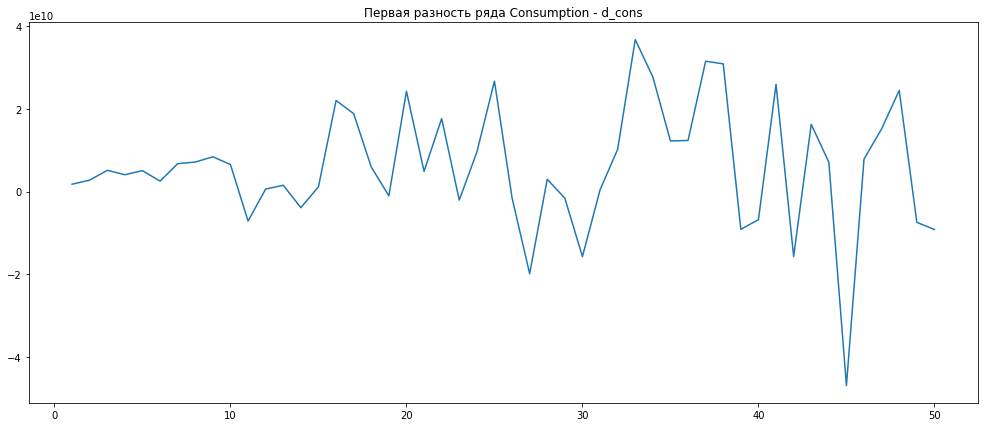

In [34]:
print(d_cons.plot(kind = 'line', 
                title = 'Первая разность ряда Consumption - d_cons', 
                 figsize = (17, 7)))

### ADF-тест для d_cons

In [35]:
d_cons_adf = ADF(d_cons, trend = 'ct')
print(d_cons_adf.summary())
print('\n')
print(d_cons_adf.regression.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.991
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.16 (1%), -3.50 (5%), -3.18 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     18.00
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           1.68e-06
Time:                        22:17:44   Log-Likelihood:                -1217.1
No. Observations:                  49   AIC:                             2440.
Df Residuals:                      46   BIC:          

### KPSS-тест для d_cons

In [36]:
# Проверка первой разности Consumption на стационарность
kpss_d_cons = KPSS(d_cons, trend = 'ct')
print(kpss_d_cons.summary())

    KPSS Stationarity Test Results   
Test Statistic                  0.074
P-value                         0.316
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


### ВЫВОД: согласно результатам обоих тестов, первая разность ряда CONS стационарна. Тестовая статистика в обоих тестах попадает в зону принятия гипотезы о TS-характере процесса, сам тренд *статистически незначим* = нулевой. Таким образом, ряд действительно стационарный

<hr>

### Первая разность GDP - d_GDP

In [37]:
# Первая разность ряда GDP 
d_GDP = final_AUS.GDP.diff().dropna()

AxesSubplot(0.125,0.125;0.775x0.755)


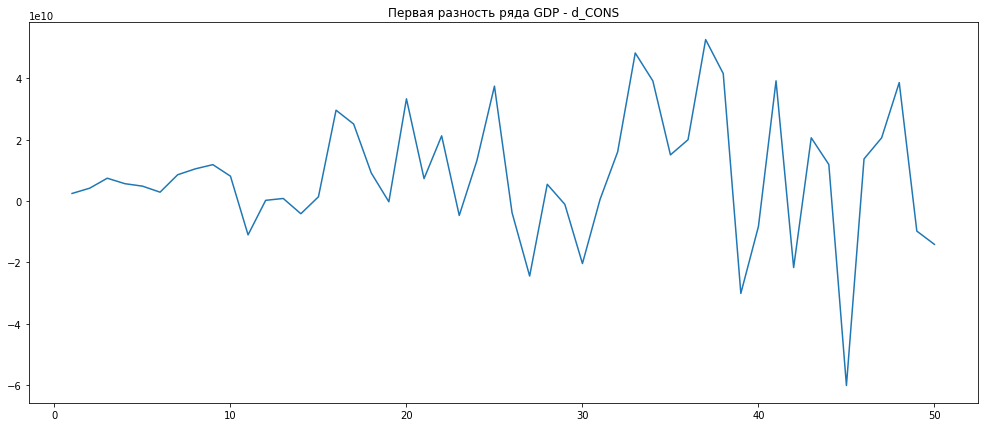

In [38]:
print(d_GDP.plot(kind= 'line', 
                 title = 'Первая разность ряда GDP - d_CONS', 
                figsize = (17, 7)))

### ADF-тест для d_GDP

In [39]:
### ADF-тест для d_cons
d_GDP_adf = ADF(d_GDP, trend = 'ct')
print(d_GDP_adf.summary())
print('\n')
print(d_GDP_adf.regression.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.549
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.16 (1%), -3.51 (5%), -3.18 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     13.39
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           2.41e-06
Time:                        22:17:45   Log-Likelihood:                -1208.2
No. Observations:                  48   AIC:                             2424.
Df Residuals:                      44   BIC:          

### KPSS-тест для d_GDP

In [40]:
d_GDP_kpss = KPSS(d_GDP, trend = 'ct')
print(d_GDP_kpss.summary())
print('\n')

    KPSS Stationarity Test Results   
Test Statistic                  0.069
P-value                         0.352
Lags                                4
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.




### ВЫВОД: 
#### согласно результатам обоих тестов, первая разность ряда GDP стационарна. Тестовая статистика в обоих тестах попадает в зону принятия гипотезы о TS-характере процесса, сам тренд статистически незначим = нулевой. Таким образом, ряд действительно стационарный
<br>
<br>

### ОБЩИЙ ВЫВОД: порядок интегрирования обоих рядов = 1

<hr> 

# Задача 2. Тест Грейнджера для выявления причинности (на стационарных рядах)

Пояснение: как работает реализация теста Грейнджера в Python? 

In [41]:
d_cons_gdp = final_AUS[['consumption', 'GDP']].diff().dropna()

#### Случай А. Является ли d_GDP причинностью по Грейнджеру для d_cons? (ВВП для потребления) (порядок лага - до 7)

In [42]:
g_caus = timeseries.stattools.grangercausalitytests(d_cons_gdp[['consumption', 'GDP']], maxlag = [7], verbose = True)


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.0025  , p=0.0002  , df_denom=28, df_num=7
ssr based chi2 test:   chi2=64.5274 , p=0.0000  , df=7
likelihood ratio test: chi2=39.4114 , p=0.0000  , df=7
parameter F test:         F=6.0025  , p=0.0002  , df_denom=28, df_num=7


#### ВЫВОД: р-значение принятия Н(0) об отсутствии влияния d_GDP на d_cons во всех случаях существенно ниже уровня значимости (5%). ДА, ВВП действительно является причинностью по Грейнджеру для потребления 

#### Случай В. Является ли d_cons причинностью по Грейнджеру для d_GDP? (потребление для ВВП) (порядок лага - до 7)

In [43]:
g_caus = timeseries.stattools.grangercausalitytests(d_cons_gdp[['GDP','consumption']], maxlag = [7], verbose = True)


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=7.3483  , p=0.0000  , df_denom=28, df_num=7
ssr based chi2 test:   chi2=78.9939 , p=0.0000  , df=7
likelihood ratio test: chi2=44.8391 , p=0.0000  , df=7
parameter F test:         F=7.3483  , p=0.0000  , df_denom=28, df_num=7


#### ВЫВОД: р-значение принятия Н(0) об отсутствии влияния d_GDP на d_cons во всех случаях существенно ниже уровня значимости (5%). ДА, потребление действительно является причинностью для ВВП

### ОБЩИЙ ВЫВОД: 
### Тест Грейнджера позволил установить причинность В ОБЕ СТОРОНЫ: d_GDP является причинностью для d_cons и наоборот. Однако причинность выражено *слабо*, поскольку подтвердилась лишь на 7 лаге.
### Важно заметить, что отсутствие причинности по Г. для первых разностей необязательно означает отсутствие этой причинности для *исходных временных рядов*. Подробнее причинность для исходных рядов исследована в Задаче 7 (Построение VECM-модели). 

<hr>

# Задача 3. Оценка модели ARIMA(p,d,q) для одного из рядов

### Ряд d_cons (потребление): выбор p, q для ARIMA (p, 1, q)  на основе анализа ACF и PACF

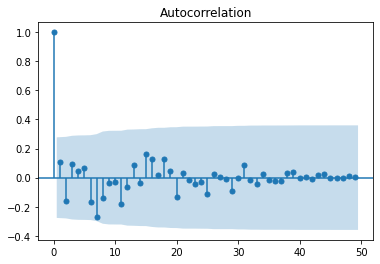

In [44]:
# ACF и PACF для ряда d_cons
# d_cons_acf = timeseries.stattools.acf(d_cons)
plot_acf_d_cons = sm.graphics.tsa.plot_acf(d_cons, lags = len(d_cons)-1)

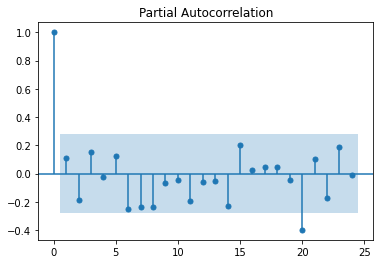

In [45]:
plot_pacf_d_cons = sm.graphics.tsa.plot_pacf(d_cons, lags = 24)

### Построение модели ARIMA (1, 1, 1)

In [46]:
arima_1_1_1 = timeseries.arima.ARIMA(final_AUS.consumption, order = (1, 1, 1)).fit()
print(arima_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:            consumption   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1243.166
Date:                Mon, 27 Dec 2021   AIC                           2492.331
Time:                        22:17:46   BIC                           2498.067
Sample:                             0   HQIC                          2494.516
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5412      0.292     -1.853      0.064      -1.114       0.031
ma.L1          0.8198      0.200      4.094      0.000       0.427       1.212
sigma2      2.567e+20   2.31e-22   1.11e+42      0.0

In [47]:
print(f'Корни характеристического уравнения по модулю: \n для AR - {abs(arima_1_1_1.arroots[0])}, \n для МА - {abs(arima_1_1_1.maroots[0])}')

Корни характеристического уравнения по модулю: 
 для AR - 1.847681786676704, 
 для МА - 1.2198089974202113


### ВЫВОДЫ: 
#### АВТОКОРРЕЛЯЦИЯ:  р-значение принятия Н(0) в тесте Ljung-Box(Q) = 49%, что выше уровня значимости. Нулевая гипотеза об отсутствии АК принимается. 
#### КОРНИ ХАРАКТЕРИСТИЧЕСКИХ УРАВНЕНИЙ: как для AR, так и для MA части больше единицы по модулю, т.е. лежат вне единичного круга. Модель действительно описывает стационарный процесс. 

<hr>

### Построение прогноза и доверительного интервала по ARIMA(1,1,1) на 1 шаг вперед

In [48]:
forecast = arima_1_1_1.get_forecast().summary_frame()
forecast.columns = ['Прогноз', 'Стандартная ошибка', 'Нижняя граница ДИ', 'Верхняя граница ДИ']

In [49]:
forecast

,Прогноз,Стандартная ошибка,Нижняя граница ДИ,Верхняя граница ДИ
51,3.122900e+11,1.602274e+10,2.808860e+11,3.436940e+11


<hr>

# Задача 4. Проверка наличия ARCH-эффекта в остатках модели ARIMA (1,1,1) с помощью теста Ингла (ARCH-LM test)

#### Выделение остатков

In [50]:
arima111_resid = arima_1_1_1.resid

<AxesSubplot:title={'center':'Остатки модели ARIMA (1, 1, 1)'}>

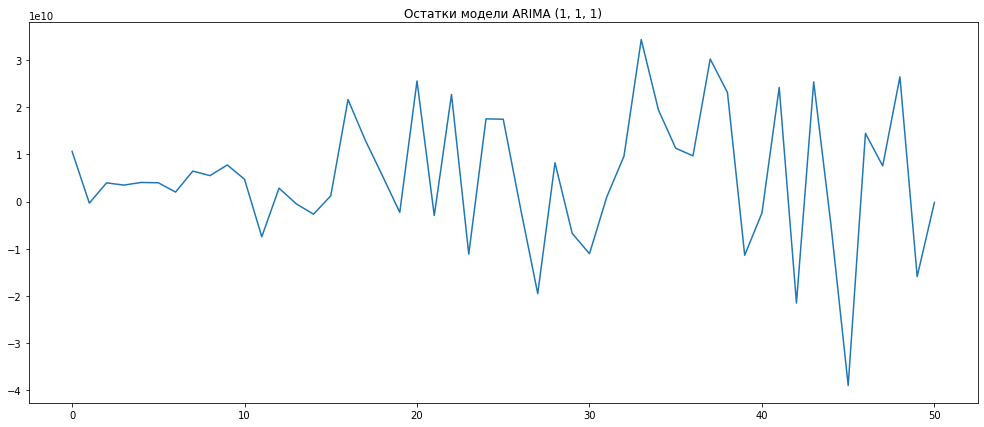

In [51]:
arima111_resid.plot(kind = 'line',
                    figsize = (17, 7), 
                    title = 'Остатки модели ARIMA (1, 1, 1)')

<hr>

### Тест Энгла на ARCH-эффект в остатках ARIMA-модели (ARCH-LM test)
#### Нулевая гипотеза (Н0): в остатках модели ARCH-эффекта не наблюдается
#### Альтернативная гипотеза (Н1): в остатках модели есть ARCH-эффект. 
#### Тестируемая статистика: LM

In [52]:
arch_eff_results = sm.stats.diagnostic.het_arch(arima111_resid, nlags = 25)
print(f'LM-статистика расчетная = {arch_eff_results[0]}\nP-значение = {arch_eff_results[1]}')

LM-статистика расчетная = 23.04670881474513
P-значение = 0.5748357716843808


### ВЫВОД: р-значение принятия H0 = 57,5%. Несмотря на подтвержденную гетероскедастичноть, выявить связь текущих и прошлых значений ошибок (ARCH-эффект) не удалось. GARCH-модель строиться не будет.

<hr>

# Задача 5. Коинтеграция по Инглу-Грейнджеру и модель коррекции ошибок (ECM)

Согласно процедуре Ингла-Грейнджера, 
<br>**Шаг 1.** Оба ряда должны быть одного порядка интегрируемости. Это уже проверено ранее. 
<br>**Шаг 2.** Коинтегрирующий вектор в нашем случае неизвестен. Тогда для построения модели коинтеграции линейная комбинация двух рядов должна быть стационарной

<br>Поскольку тест на причинность по Грейнджеру показал **причинность в обе стороны**, построим две модели коинтеграции. 

In [53]:
final_dataset = final_AUS[['consumption', 'GDP']]

In [54]:
final_dataset.loc[:, 'constant'] = 1

### Модель коинтеграции Y = cons, X = GDP, включая константу

In [55]:
cointegration_GDP_cons = sm.OLS(endog = final_dataset.consumption, 
                                exog = final_dataset[['GDP', 'constant']]).fit()

In [56]:
print(cointegration_GDP_cons.summary())

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.803e+04
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           5.57e-77
Time:                        22:17:47   Log-Likelihood:                -1186.4
No. Observations:                  51   AIC:                             2377.
Df Residuals:                      49   BIC:                             2381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDP            0.7206      0.003    240.898      0.0

**Промежуточный вывод:** коэффициенты параметров модели статистически значимы: р-значения в тестах Стьюдента - 0% и 0,07%, ниже уровня значимости. Уравнение значимо в целом: р-значение в тесте Фишера близко к 0. 

#### Модель коинтеграции Y = GDP, X = cons, включая константу

In [57]:
cointegration_cons_GDP = sm.OLS(endog = final_dataset.GDP, 
                                exog = final_dataset[['consumption', 'constant']]).fit()

In [58]:
print(cointegration_cons_GDP.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.803e+04
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           5.57e-77
Time:                        22:17:48   Log-Likelihood:                -1203.1
No. Observations:                  51   AIC:                             2410.
Df Residuals:                      49   BIC:                             2414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
consumption     1.3866      0.006    240.898      

#### AIC и BIC в первой модели ниже, поэтому принимаем ее за лучшую из двух и работаем с ее остатками: строим модель ЕСМ

<hr>

### Выделяем остатки первой модели коинтеграции (Y = cons, X = GDP)

In [59]:
resids_coint_model = cointegration_GDP_cons.resid

### Проверяем остаки на стационарность с помощью теста ADF

In [60]:
resids_adf = ADF(resids_coint_model, trend = 'n')
print(f'{resids_adf.summary()}\n\n\nВСПОМОГАТЕЛЬНАЯ РЕГРЕССИЯ ADF БЕЗ КОНСТАНТЫ И ТРЕНДА\n\n{resids_adf.regression.summary()}')

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.035
P-value                         0.040
Lags                                2
-------------------------------------

Trend: No Trend
Critical Values: -2.61 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ВСПОМОГАТЕЛЬНАЯ РЕГРЕССИЯ ADF БЕЗ КОНСТАНТЫ И ТРЕНДА

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.205
Method:                 Least Squares   F-statistic:                              5.136
Date:                Mon, 27 Dec 2021   Prob (F-statistic):                     0.00386
Time:                        22:17:48   Log-Likelihood:                         -1097.9
No. Observations:                  48   AIC:   

### Тест LJUNG-BOX (Q) на автокорреляцию в остатках
#### Проверяем остатки вспомогательной регрессии ADF на наличие АК

In [61]:
print(sm.stats.acorr_ljungbox(resids_adf.regression.resid, return_df = True))

      lb_stat  lb_pvalue
1    0.042562   0.836551
2    0.043540   0.978465
3    0.107650   0.990904
4    0.367144   0.985077
5    1.418109   0.922322
6    1.642710   0.949458
7    3.750085   0.808071
8    4.076518   0.850155
9    5.914395   0.748454
10   5.916065   0.822265
11   6.079346   0.868018
12   6.351975   0.897310
13   7.220724   0.890421
14   7.363499   0.919790
15   7.374180   0.946423
16   8.381883   0.936676
17   9.587725   0.920003
18   9.689683   0.941565
19   9.864299   0.956214
20  10.184338   0.964705
21  10.238314   0.975649
22  10.746912   0.978175


#### ВЫВОД: р-значение принятия нулевой гипотезы об отсутствии автокорреляции в тесте Ljung-Box(Q) ВПЛОТЬ ДО 22 ЛАГА - около 98%. Ни для одного из лагов р-значение не ниже 70% (очень высокий показатель). Это означает, что автокорреляции в остатках вспомогательной ADF-регрессии не наблюдается, и данное уравнение можно использовать как тестовое при определении стационарности линейной комбинации

### ВЫВОД ПО ADF-ТЕСТУ: 
#### Тестовая статистика = -1,998
#### Критическая ADF для коинтеграции из таблицы = -3,6
#### Принимается  Н(0) о DS-характере ряда остатков: остатки нестационарны 
#### Коинтеграция не найдена, ЕСМ построена быть не может

<hr>

# Задача 6. Оценка VAR на стационарных рядах

In [62]:
VAR_model = timeseries.VAR(endog = d_cons_gdp)

c:\users\vsevo\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [63]:
lag_order = VAR_model.select_order(maxlags = 15, trend = 'n')

In [64]:
print(f"Выбранный лаг:\nAIC - {lag_order.selected_orders['aic']}\nBIC - {lag_order.selected_orders['bic']}\nFPE - {lag_order.selected_orders['fpe']}\nHQIC - {lag_order.selected_orders['hqic']}\n")
print(lag_order.summary())

Выбранный лаг:
AIC - 15
BIC - 15
FPE - 15
HQIC - 15

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        91.46       91.46   5.241e+39       91.46
1        91.54       91.72   5.718e+39       91.61
2        91.55       91.91   5.774e+39       91.67
3        91.66       92.20   6.487e+39       91.85
4        91.81       92.52   7.575e+39       92.05
5        91.98       92.87   9.116e+39       92.28
6        91.39       92.46   5.193e+39       91.76
7        91.58       92.82   6.483e+39       92.00
8        91.69       93.11   7.667e+39       92.18
9        91.16       92.76   4.837e+39       91.71
10       91.19       92.97   5.508e+39       91.81
11       91.17       93.12   6.090e+39       91.84
12       90.05       92.18   2.373e+39       90.78
13       90.21       92.52   3.527e+39       91.00
14       89.42       91.91   2.249e+39       90.28
15      88.14*      90.81*  1

#### ВЫВОД: наименьшее значение инфомационных критериев для р = 15. Таким образом, строим VAR(15, 2)

In [65]:
var_model_results = VAR_model.fit(15)
print(var_model_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Dec, 2021
Time:                     22:17:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    90.4703
Nobs:                     35.0000    HQIC:                   88.6662
Log likelihood:          -1572.34    FPE:                9.78439e+38
AIC:                      87.7152    Det(Omega_mle):     2.75158e+38
--------------------------------------------------------------------
Results for equation consumption
                        coefficient          std. error           t-stat            prob
----------------------------------------------------------------------------------------
const            22623163436.048698  17139696719.483269            1.320           0.187
L1.consumption             0.448124            3.531649            0.127           0.899
L1.GDP                

#### Значимых лагов для VAR в первых разностях не обнаружено.

### F-тесты (тесты на причинность по Грейнджеру) для уравнений VAR

In [66]:
caus_test_1 = var_model_results.test_causality(caused = 'consumption', causing = 'GDP')

In [67]:
print(caus_test.summary())

NameError: name 'caus_test' is not defined

In [ ]:
caus_test_2 = var_model_results.test_causality(causing = 'consumption', caused = 'GDP')
print(caus_test_2.summary())

### Комментарий: F-тесты на причинность по Грейнеджеру на позволили подтвердить ее наличие для первых разностей. В тесте на причинность по Г. в Задаче 3 причинность подтвердилась лишь на 7 лаге. 
### Однако отсутствие причинности по Грейнджеру в первых разностях не означает ее отсутствие для *исходных* временных рядов: для проверки этого необходимо проводить тест Йохансена и стороить VECM и смотреть, *значимы ли коэффициенты корректировок*

<hr>

# Задача 7. Тест Йохансена и оценка VECM

In [ ]:
VAR_non_stationary = timeseries.VAR(final_AUS[['consumption', 'GDP']])

In [ ]:
lag_order_VECM = VAR_non_stationary.select_order(maxlags = 15, trend = 'c')

In [ ]:
print(lag_order_VECM.summary())

### Тест Йохансена (порядок лага = 15)

In [ ]:
coint_rank = select_coint_rank(endog = final_dataset[['GDP', 'consumption']], det_order = 0, k_ar_diff = 15, method = 'maxeig')
print(coint_rank.summary())

In [ ]:
coint_rank.rank

#### ВЫВОД: 
#### Cогласно результатам теста Йохансена, принимается  Н(0) о наличии одного коинтеграционного соотношения. 
#### Гипотеза о нулевом ранге матрицы долгосрочных соотношений (П) отвергается, так как тестовая статистика больше критической: 71.46 > 14.26

### Оценка VECM-системы (порядок лага = 15, ранг коинтеграции = 1), анализ причинности в рамках VECM, уравнение долгосрочного соотношения

In [ ]:
vecm_12 = timeseries.VECM(endog = final_dataset[['GDP', 'consumption']], 
               exog = None, 
               k_ar_diff = 14### Тест Йохансена (порядок лага = 15), 
               coint_rank = 1).fit()

In [ ]:
print(vecm_12.summary())

### ВЫВОД: 
### Коэффициенты корректировки в *обоих уравнениях* VECM-модели для исходных временных рядов все же статистически значимы: р-значения принятия нулевых гипотез об их незначимости = 0. 
### А это означает, что причинность по Грейнджеру для *исходных временных рядов* все же ЕСТЬ, причем в оба направления. 
### Долгосрочное соотношение: GDP = 1.4402 * consumption

<hr>

# Задача 8. Заключение по результатам проекта

Результаты проведения проекта позволяют сделать следующие выводы в отношении поставленных гипотез: 
<br><br>**Гипотеза 1** о DS-харакетере рядов ВВП и потребления принимается: оба ряда действительно имеют первый порядок интегрируемости, что было подтверждено мощным тестом ADF-GLS 
<br><br>**Гипотеза 2** о возможности ECM и VECM, а также о наличии коинтеграционного соотношения и статистической значимости коэффициентов корректировки, подтверждается частично: все было предположено верно, кроме возможности построить линейную ЕСМ: данная модель не получилась из-за отсутствия коинтеграции по Инглу-Грейнджеру. Модель VECM была построена *вплоть до 15 лага,* оба коэффициента корректировки оказались статистически значимыми.  
<br><br>**Гипотеза 3** о возможности построения модели ARIMA (p,d,q) подтверждается полностью: анализ PACF и ACF выявил значимые лаги (первого порядка), в итоге получилась модель ARIMA (1,1,1) для ряда потребления (то есть ARMA (1,1,) для *его первой разности*)
<br><br>**Гипотеза 4** о наличии ARCH-эффекта в остатках модели ARIMA(1,1,1) отвергается: тест ARCH-LM по Инглу позволил принять нулевую гипотезу об отсутствии ARCH-эффекта